# Import packages

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Load data

In [30]:
data_file_name = 'dataset.xlsx'
data_dir_path = '.'
data_file_path = os.path.join(data_dir_path, data_file_name)

# Load 'data' spreadsheet
df = pd.read_excel(open(data_file_path, 'rb'), sheetname='data', header=1)

# print(df.head())
# print(df.columns)

# 1) Preprocessing - fill in missing values

# Defin a function

In [31]:
def fill_in_missing_data(data, window_size):
    num_of_data = len(data)
    indices = np.where(np.isnan(data))[0]

    for i in indices:
        values = []
        distances = []
        for j in range(1,window_size+1):
            if i-j >= 0 and not np.isnan(data[i-j]):
                values.append(data[i-j])
                distances.append(j)
            if i+j < num_of_data and not np.isnan(data[i+j]):
                values.append(data[i+j])
                distances.append(j)

        values = np.array(values)
        distances = np.array(distances)
        inverse_distances = 1.0 / distances
        weights = inverse_distances / np.sum(inverse_distances)
        filling_value = np.sum(np.multiply(values, weights))
        data[i] = filling_value
    return data

def test_fill_in_missing_data(data, window_size):
    modified_data = fill_in_missing_data(np.copy(data), 3)
    plt.plot(modified_data)
    plt.show()
#     data[np.where(np.isnan(data))] = 0
#     plt.plot(data)
#     plt.ylim(1800, 2100)
#     plt.show()
    

# Fill in missing values - Kospi & Kosdaq

In [32]:
kospi = df['KOSPI']
kosdaq = df['KOSDAQ']

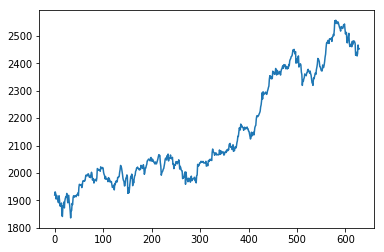

In [33]:
test_fill_in_missing_data(np.copy(kospi),3)

In [34]:
# fill in missing values
window_size = 3
df['KOSPI'] = fill_in_missing_data(np.copy(kospi), window_size)
df['KOSDAQ'] = fill_in_missing_data(np.copy(kosdaq), window_size)

# 2) Preprocessing - add 'season' feature based on 'date'

In [35]:
season_as_num = df['Date'].apply(lambda dt: (dt.month%12 + 3)//3)
df['Season'] = np.where(season_as_num == 1, 'winter', 
                            (np.where(season_as_num == 2, 'spring',
                                     np.where(season_as_num == 3, 'summer', 'fall'))))

# 3) Preprocessing - add 'Average_Temperature_Normalized'

In [36]:
df['Average_Temperature_Normalized'] = np.zeros_like(df['Average_Temperature'])

In [37]:
month = 0
season = None
indices = []
avg_temperatures = []
for i, date in enumerate(df['Date']):
    if month == 0:
        month = date.month
        season = df['Season'][i]
    indices.append(i)
    avg_temperatures.append(df['Average_Temperature'][i])
    if i == len(df['Date'])-1:
        mean_avg_temperature = np.mean(avg_temperatures)
        sd_avg_temperature = np.std(avg_temperatures)
        if season == 'spring' or season == 'summer':
            df['Average_Temperature_Normalized'][indices] = (mean_avg_temperature - df['Average_Temperature'][indices]) / sd_avg_temperature
        else:
            df['Average_Temperature_Normalized'][indices] = (df['Average_Temperature'][indices] - mean_avg_temperature) / sd_avg_temperature
    elif month != date.month:
        mean_avg_temperature = np.mean(avg_temperatures[:-1])
        sd_avg_temperature = np.std(avg_temperatures[:-1])
        if season == 'spring' or season == 'summer':
            df['Average_Temperature_Normalized'][indices] = (mean_avg_temperature - df['Average_Temperature'][indices]) / sd_avg_temperature
        else:
            df['Average_Temperature_Normalized'][indices] = (df['Average_Temperature'][indices] - mean_avg_temperature) / sd_avg_temperature
        month = date.month
        indices = [i]
        avg_temperatures = [df['Average_Temperature'][i]]
    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


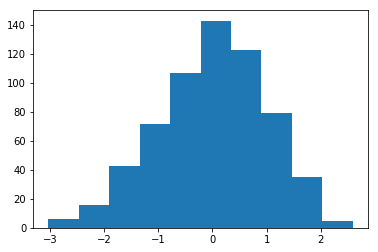

In [38]:
plt.hist(df['Average_Temperature_Normalized'])
plt.show()

# 4) Preprocessing - classify 'Revenue' for classification

# Add 'Revenue_Normalized' variable to see how 'Revenue' has changed

In [39]:
df['Revenue_Normalized'] = np.zeros_like(df['Revenue'])

In [40]:
month = 0
indices = []
revenues = []
mean_revenues = []
sd_revenues = []
for i, date in enumerate(df['Date']):
    if month == 0:
        month = date.month
    indices.append(i)
    revenues.append(df['Revenue'][i])
    if i == len(df['Date'])-1:
        mean_revenue = np.mean(revenues)
        sd_revenue = np.std(revenues)
        df['Revenue_Normalized'][indices] = (df['Revenue'][indices] - mean_revenue) / sd_revenue
    elif month != date.month:
        mean_revenue = np.mean(revenues[:-1])
        sd_revenue = np.std(revenues[:-1])
        df['Revenue_Normalized'][indices] = (df['Revenue'][indices] - mean_revenue) / sd_revenue
        month = date.month
        indices = [i]
        revenues = [df['Revenue'][i]]
        mean_revenues.append(mean_revenue)
        sd_revenues.append(sd_revenue)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


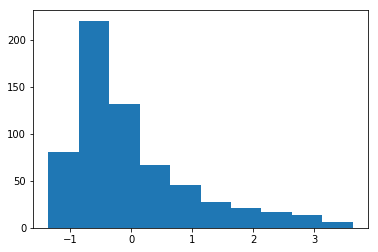

In [41]:
plt.hist(df['Revenue_Normalized'])
plt.show()

# Classify 'Revenue'

In [42]:
rate = df['Revenue_Normalized']
df['Rate_Class'] = np.where(rate > 0.7, 'very high', 
                            (np.where(rate > 0.3, 'high',
                                     np.where(rate > -0.3, 'moderate',
                                             np.where(rate > -0.7, 'low', 'very low')))))

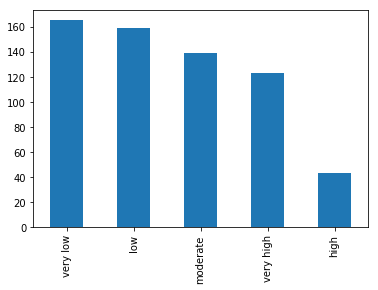

In [43]:
# Show the distribution of 'Rate Class'
df['Rate_Class'].value_counts().plot(kind='bar')
plt.show()

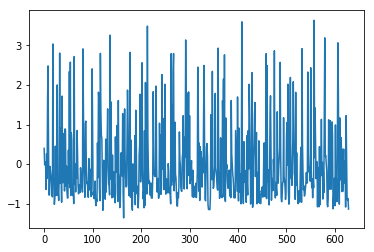

In [44]:
plt.plot(rate.tolist())
plt.show()

# 5) Preprocessing - Normalization

# Define a function

In [45]:
def normalize(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.mean(data)
    denominator = np.std(data)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

# All Variables except 'Date', 'Rate_Class', 'Season' and normalized variables

In [46]:
df.columns

Index([                          u'Date',                          u'KOSPI',
                               u'KOSDAQ',            u'Average_Temperature',
                   u'Lowest_Temperature',            u'Highest_temperature',
                        u'Precipitation',             u'Average_Wind_Speed',
            u'Average_Relative_humidity',                 u'Daylight_Hours',
                          u'Cloud_Cover',                u'Duration_of_Fog',
                              u'Revenue',                        u'Fitness',
                        u'Sports_Center',                            u'Gym',
                                 u'Diet',                           u'Body',
                  u'Busan_Sports_Center',                      u'Busan_Gym',
                               u'Season', u'Average_Temperature_Normalized',
                   u'Revenue_Normalized',                     u'Rate_Class'],
      dtype='object')

In [47]:
columns = [x for x in df.columns if x not in ['Date', 'Rate_Class', 'Season', 'Average_Temperature_Normalized', 'Revenue_Normalized']]
print(columns)
df_scaled = df.copy()
df_scaled[columns] = df_scaled[columns].apply(normalize, axis=0)
df_scaled['Date'] = df['Date']
df_scaled['Rate_Class'] = df['Rate_Class']

[u'KOSPI', u'KOSDAQ', u'Average_Temperature', u'Lowest_Temperature', u'Highest_temperature', u'Precipitation', u'Average_Wind_Speed', u'Average_Relative_humidity', u'Daylight_Hours', u'Cloud_Cover', u'Duration_of_Fog', u'Revenue', u'Fitness', u'Sports_Center', u'Gym', u'Diet', u'Body', u'Busan_Sports_Center', u'Busan_Gym']


# Final dataset - Done with preprocessing

In [48]:
# Debugging
df_scaled.fillna(0, inplace=True)
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_scaled.isnull().values.any()
nan_rows = df_scaled[df_scaled.isnull().T.any().T]
nan_rows

height has been deprecated.



,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,Cloud_Cover,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym,Season,Average_Temperature_Normalized,Revenue_Normalized,Rate_Class


In [49]:
df_scaled.head()

,Date,KOSPI,KOSDAQ,Average_Temperature,Lowest_Temperature,Highest_temperature,Precipitation,Average_Wind_Speed,Average_Relative_humidity,Daylight_Hours,Cloud_Cover,Duration_of_Fog,Revenue,Fitness,Sports_Center,Gym,Diet,Body,Busan_Sports_Center,Busan_Gym,Season,Average_Temperature_Normalized,Revenue_Normalized,Rate_Class
0,2016-01-04,-1.151953,0.287214,-0.608890,-0.506602,-0.574746,-0.285686,-0.016943,0.342568,-0.836233,-1.467212,-0.122031,0.483480,0.734342,0.903352,3.990658,2.044022,1.343423,2.862245,4.261320,winter,2.591066,0.399221,high
1,2016-01-05,-1.092558,0.436134,-1.216455,-0.994161,-1.469336,-0.267387,0.016230,0.183380,-1.126611,0.202475,-0.122031,0.097475,0.660965,0.360811,2.008003,1.305837,0.905758,-0.567634,2.863554,winter,0.857798,-0.017328,moderate
2,2016-01-06,-1.118294,0.512017,-1.276020,-1.149293,-1.242539,-0.285686,-0.000357,-0.005287,-0.866621,-0.174551,-0.122031,0.161809,1.553687,-0.026693,1.459698,1.545523,0.853020,-0.274840,2.475287,winter,0.687870,0.052096,moderate
3,2016-01-07,-1.224771,0.331558,-1.383237,-1.226859,-1.418937,-0.285686,-0.016943,0.372047,-0.836233,-1.440282,-0.122031,0.071741,0.587588,0.070194,0.846762,1.643549,1.723091,-0.442151,2.785901,winter,0.381999,-0.045098,moderate
4,2016-01-08,-1.157706,0.400327,-1.550020,-1.404153,-1.620535,-0.285686,-0.000357,0.277713,-0.819350,-1.467212,-0.122031,-0.481532,-0.268431,-0.220422,0.083722,1.214685,1.021763,-0.818601,0.689253,winter,-0.093800,-0.642152,low


# Save the data in excel format

In [50]:
import openpyxl

In [51]:
df_scaled.to_excel('df_scaled.xlsx', sheet_name='sheet1', index=False)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/io/excel.py:784: DeprecationWarning: Call to deprecated function remove_sheet (Use wb.remove(worksheet) or del wb[sheetname]).
  self.book.remove_sheet(self.book.worksheets[0])
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:16.001252. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Regression Models

# Create dataset

In [52]:
# define a function to create dataset
def create_dateset(variables, seq_len):
    dataX = []
    dataY = []
    for i in range(df_scaled.shape[0] - seq_len):
        _x = df_scaled.loc[i:i+seq_len-1, variables].values
        _y = [df_scaled.loc[i+seq_len, 'Revenue_Normalized']]
        dataX.append(_x)
        dataY.append(_y)
    return dataX, dataY

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:16.764637. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create train, validation and test set

In [53]:
def split_dataset(dataX, dataY, train_data_rate, val_data_rate, model):
    train_size = int(len(dataY)*train_data_rate)
    val_size = int(len(dataY)*val_data_rate)
    test_size = len(dataY) - train_size - val_size

    if model=='linear':
        trainX, valX, testX = np.array(dataX[:train_size]).reshape((train_size, -1)),\
                                       np.array(dataX[train_size:train_size+val_size]).reshape((val_size, -1)),\
                                       np.array(dataX[train_size+val_size:len(dataX)]).reshape((test_size, -1))
        trainY, valY, testY = np.array(dataY[:train_size]).reshape((train_size, -1)),\
                                       np.array(dataY[train_size:train_size+val_size]).reshape((val_size, -1)),\
                                       np.array(dataY[train_size+val_size:len(dataY)]).reshape((test_size, -1))
    elif model=='lstm':
        trainX, valX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:train_size+val_size]), np.array(dataX[train_size+val_size:len(dataX)])
        trainY, valY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:train_size+val_size]), np.array(dataY[train_size+val_size:len(dataY)])
    return (trainX, valX, testX, trainY, valY, testY)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:16.781345. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Error calculator

In [54]:
def calculate_error(trained_model, X, Y):
    def _rmse(target, pred):
        error = np.sqrt(np.mean(np.square(target - pred)))
        return error
    pred = trained_model.predict(X)
    rmse_error = _rmse(Y, pred)
    return rmse_error

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:16.803822. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Validate seq_len

In [55]:
def validate_seq_len(seq_len_list, train_data_rate, val_data_rate, model):
    val_rmse_errors = []
    for seq_len in seq_len_list:
        dataX, dataY = create_dateset(regression_variables, seq_len)
        (lm_trainX, lm_valX, lm_testX, lm_trainY, lm_valY, lm_testY) = \
        split_dataset(dataX, dataY, train_data_rate, val_data_rate, model)
        lm = linear_model(lm_trainX, lm_trainY)
        val_rmse_error = calculate_error(lm, lm_valX, lm_valY)
        val_rmse_errors.append(val_rmse_error)
    plt.plot(seq_len_list, val_rmse_errors)
    plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:16.820878. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Define variables to use

In [56]:
# Hyperparameters for Linear model. Tune these variables.
regression_variables = df_scaled.columns.tolist()
variables_to_remove = ['Date', 'Rate_Class', 'Revenue', 'Season', 
                       'Average_Temperature', 'Lowest_Temperature',
                       'Highest_temperature', 'Fitness', 'Gym', 'Diet',
                       'Body', 'Duration_of_Fog', 'Sports_Center', 
                       'Busan_Sports_Center', 'Busan_Gym', 'Average_Relative_humidity',
                       'Average_Wind_Speed', 'Daylight_Hours', 'Cloud_Cover']

for variable in variables_to_remove:
    regression_variables.remove(variable)
print(regression_variables)

[u'KOSPI', u'KOSDAQ', u'Precipitation', 'Average_Temperature_Normalized', 'Revenue_Normalized']


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:16.844766. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# 1) Linear Model

# Import additional packages 

In [57]:
from sklearn.linear_model import LinearRegression

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:16.866747. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Define a function to create and train linear model

In [58]:
def linear_model(lm_trainX, lm_trainY, fit_intercept=True, normalize=False, copy_X=True):
    lm = LinearRegression(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X)
    lm.fit(lm_trainX, lm_trainY)
    return lm

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:18.026766. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


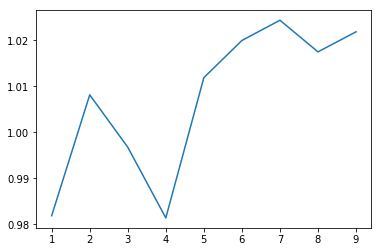

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:18.043835. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [59]:
validate_seq_len(seq_len_list=[1,2,3,4,5,6,7,8,9], train_data_rate=0.6, val_data_rate=0.25, model='linear')

# Assign hyperparameters

In [60]:
seq_len = 4

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:28.369999. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create and split dataset

In [61]:
dataX, dataY = create_dateset(regression_variables, seq_len=seq_len)
(lm_trainX, lm_valX, lm_testX, lm_trainY, lm_valY, lm_testY) = \
        split_dataset(dataX, dataY, 0.6, 0.25, 'linear')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:28.379403. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Train linear model

In [62]:
lm = linear_model(lm_trainX, lm_trainY, fit_intercept=True, normalize=False, copy_X=True)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:29.298934. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Evaluation

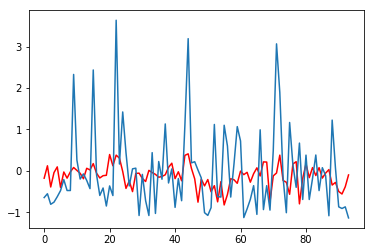

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:29.310334. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [63]:
test_pred = lm.predict(lm_testX)
plt.plot(test_pred, color='red')
plt.plot(lm_testY)
plt.show()

In [64]:
test_error = calculate_error(lm, lm_testX, lm_testY)
print(test_error)

0.959648817247728


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:29.568431. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# 2) LSTM 

# Import additional packages 

In [65]:
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:53:29.581531. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Assign hyperparameters 

In [128]:
# Hyperparameters for LSTM model. Tune these variables.
# Fixed hyperparameters
data_dim = len(regression_variables)
output_dim = 1

seq_len = 4
hidden_dim = 20
iterations = 150

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:22:58.654943. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create dataset for lstm model

In [122]:
dataX, dataY = create_dateset(seq_len=seq_len, variables=regression_variables)
(lstm_trainX, lstm_valX, lstm_testX, lstm_trainY, lstm_valY, lstm_testY) = split_dataset(dataX, dataY, 0.6, 0.25, 'lstm')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:22:16.491627. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create and train LSTM model

In [123]:
def create_lstm_model(seq_len, data_dim, output_dim, hidden_dim):
    tf.reset_default_graph()

    X = tf.placeholder(tf.float32, [None, seq_len, data_dim])
    Y = tf.placeholder(tf.float32, [None, output_dim])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
    
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.sqrt(tf.reduce_mean(tf.square(Y_pred - Y)))
    optimizer = tf.train.AdamOptimizer(0.001)
    train = optimizer.minimize(loss)
    
    predictions = tf.placeholder(tf.float32, [None, 1])
    targets = tf.placeholder(tf.float32, [None, 1])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
    return (X, Y, Y_pred, train, loss, targets, predictions, rmse)
    
def train_lstm_model(lstm_trainX, lstm_trainY, lstm_valX, lstm_valY, seq_len, data_dim, output_dim, hidden_dim, iterations):
    X, Y, Y_pred, train, loss, targets, predictions, rmse = create_lstm_model(seq_len, data_dim, output_dim, hidden_dim)
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(iterations) :
        _, _ = sess.run([train, loss], feed_dict = {X:lstm_trainX, Y:lstm_trainY})
        if i % 100 == 0:
            step_loss = sess.run(loss, feed_dict = {X:lstm_valX, Y:lstm_valY}) 
            print("Step {} - loss : {}".format(i, step_loss))
    return sess, X, Y, Y_pred, targets, predictions, rmse

def validate_error(sess, X, Y, Y_pred, targets, predictions, rmse, lstm_valX, lstm_valY, lstm_testX, lstm_testY):
    val_predict = sess.run(Y_pred, feed_dict = {X:lstm_valX})
    val_rmse_error = sess.run(rmse, feed_dict = {targets: lstm_valY, predictions : val_predict})
    print("VALIDATION RMSE ERROR : {}".format(val_rmse_error))
    test_predict = sess.run(Y_pred, feed_dict = {X:lstm_testX})
    test_rmse_error = sess.run(rmse, feed_dict = {targets : lstm_testY, predictions:test_predict})
    print("TEST RMSE ERROR : {}".format(test_rmse_error))
    
    plt.plot(lstm_valY)
    plt.plot(val_predict)
    plt.xlabel("Time Period")
    plt.show()
    plt.plot(lstm_testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.show()
    return np.reshape(test_predict, [-1])


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:22:27.856019. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [129]:
sess, X, Y, Y_pred, targets, predictions, rmse = train_lstm_model(lstm_trainX, lstm_trainY, lstm_valX, lstm_valY, seq_len, data_dim, output_dim, hidden_dim, iterations)

Step 0 - loss : 1.02736616135
Step 100 - loss : 0.977544367313


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:23:01.450716. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


VALIDATION RMSE ERROR : 0.988612651825
TEST RMSE ERROR : 0.983074903488


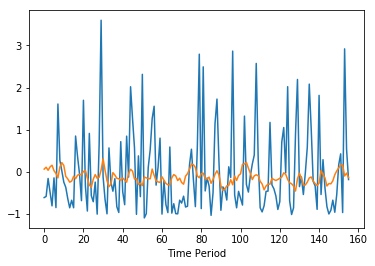

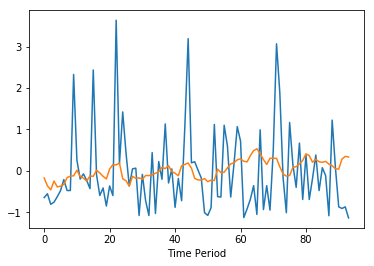

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:23:03.917810. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [130]:
test_predict = validate_error(sess, X, Y, Y_pred, targets, predictions, rmse, lstm_valX, lstm_valY, lstm_testX, lstm_testY)

In [176]:
sess.close()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 09:07:54.650499. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [131]:
def unnormalize(normalized_values, means, sds, dataY, train_data_rate, val_data_rate):
    train_size = int(len(dataY)*train_data_rate)
    val_size = int(len(dataY)*val_data_rate)
    start_idx = train_size + val_size
    end_idx = len(dataY) - 1
    # assume start_idx is from the second year
    unnormalized_values = []
    for i in range(start_idx, end_idx+1):
        month_idx = df['Date'][i].month + 12 - 2
        unnormalized_values.append(normalized_values[i-start_idx] * sds[month_idx] + means[month_idx])
    return unnormalized_values, start_idx, end_idx
    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:23:24.459082. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [132]:
predicted_revenue, start_idx, end_idx = unnormalize(test_predict, mean_revenues, sd_revenues, dataY, 0.6, 0.25)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:23:25.542398. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [133]:
true_revenue, Date = df['Revenue'][start_idx:end_idx+1], df['Date'][start_idx:end_idx+1]

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:23:26.431727. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [134]:
prediction_df = pd.DataFrame(columns = ['Date', 'True_Revenue', 'Pred_Revenue'])
prediction_df['Date'] = Date
prediction_df['True_Revenue'] = true_revenue
prediction_df['Pred_Revenue'] = np.around(predicted_revenue, decimals=-3).astype(dtype=int)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:23:27.377414. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [135]:
prediction_df

,Date,True_Revenue,Pred_Revenue
531,2017-09-04,96000,684000
532,2017-09-05,2898000,562000
533,2017-09-06,1178000,500000
534,2017-09-07,661000,637000
535,2017-09-08,327000,546000
536,2017-09-09,394000,557000
537,2017-09-11,210000,583000
538,2017-09-12,246900,690000
539,2017-09-13,341700,713000
540,2017-09-14,448000,718000


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 10:23:28.546194. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Classification Models

# 1) Decision Tree

# Import additional packages 

In [279]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import itertools

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:11.813958. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Determin which features are used

In [280]:
# Hyperparameters for Linear model. Tune these variables.
classification_variables = df_scaled.columns.tolist()
variables_to_remove = ['Date', 'Rate_Class', 'Revenue', 'Season', 'Average_Temperature', 'Lowest_Temperature', 'Highest_temperature']

for variable in variables_to_remove:
    classification_variables.remove(variable)
print(classification_variables)

[u'KOSPI', u'KOSDAQ', u'Precipitation', u'Average_Wind_Speed', u'Average_Relative_humidity', u'Daylight_Hours', u'Cloud_Cover', u'Duration_of_Fog', u'Fitness', u'Sports_Center', u'Gym', u'Diet', u'Body', u'Busan_Sports_Center', u'Busan_Gym', 'Average_Temperature_Normalized', 'Revenue_Normalized']


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:11.824098. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Assign hyperparameters 

In [281]:
# Hyperparameters for Decision Tree model. Tune these variables.
seq_len = 4

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:11.840391. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create dataset

In [282]:
# define a function to create dataset
def create_dateset(variables, seq_len):
    dataX = []
    dataY = []
    for i in range(df_scaled.shape[0] - seq_len):
        _x = df_scaled.loc[i:i+seq_len-1, classification_variables].values
        _y = [df_scaled.loc[i+seq_len, 'Rate_Class']]
        dataX.append(_x)
        dataY.append(_y)
    return dataX, dataY

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:11.851098. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create train, validation and test set

In [283]:
def split_dataset(dataX, dataY, train_data_rate, val_data_rate, model=None):
    train_size = int(len(dataY)*train_data_rate)
    val_size = int(len(dataY)*val_data_rate)
    test_size = len(dataY) - train_size - val_size


    trainX, valX, testX = np.array(dataX[:train_size]).reshape((train_size, -1)),\
                                    np.array(dataX[train_size:train_size+val_size]).reshape((val_size, -1)),\
                                    np.array(dataX[train_size+val_size:len(dataX)]).reshape((test_size, -1))
    trainY, valY, testY = np.array(dataY[:train_size]).reshape((train_size, -1)),\
                                    np.array(dataY[train_size:train_size+val_size]).reshape((val_size, -1)),\
                                    np.array(dataY[train_size+val_size:len(dataY)]).reshape((test_size, -1))
    return (trainX, valX, testX, trainY, valY, testY)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:11.867953. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [284]:
dataX, dataY = create_dateset(classification_variables, seq_len=seq_len)
dt_trainX, dt_valX, dt_testX, dt_trainY, dt_valY, dt_testY = \
    split_dataset(dataX, dataY, 0.6, 0.25)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:11.890062. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create and train Decision Tree model

In [285]:
dt = tree.DecisionTreeClassifier(max_depth=5)
dt.fit(dt_trainX, dt_trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:13.712143. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [286]:
pred_valY = dt.predict(dt_valX)
true_valY = dt_valY.reshape((-1))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:13.738348. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [287]:
cm = confusion_matrix(true_valY, pred_valY)
cm = np.stack([cm[4,:], cm[1,:], cm[2,:], cm[0,:], cm[3,:]])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:13.748574. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [288]:
classes = ['very low','low','moderate','high','very high']

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:13.761202. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [289]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def accuracy(cm):
    num_classes = len(cm)
    tp = 0
    for i in range(num_classes):
        tp += cm[i][i]
    return float(tp) / np.sum(cm)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:13.772309. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Confusion matrix, without normalization
[[ 0 14 10 11  8]
 [ 0 17  5 15  3]
 [ 0 14  6  8  2]
 [ 1  4  2  4  2]
 [ 0  8  6 10  6]]


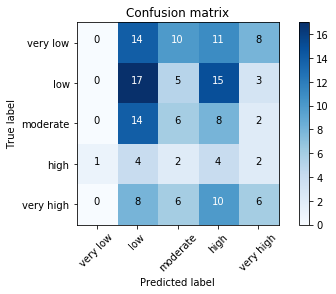

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:13.824434. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [290]:
plot_confusion_matrix(cm, classes=classes)

In [291]:
accuracy(cm)

0.21153846153846154

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.291323. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [292]:
import graphviz

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.304331. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [293]:
dot_data = tree.export_graphviz(dt, out_file='tree.dot') 

with open("tree.dot") as f:
    dot_graph = f.read()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.314604. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# 2) SVM

# Import additional packages 

In [294]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.333557. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Determin which features are used

In [295]:
# Hyperparameters for Linear model. Tune these variables.
classification_variables = df_scaled.columns.tolist()
variables_to_remove = ['Date', 'Rate_Class', 'Revenue', 'Season', 'Average_Temperature', 'Lowest_Temperature', 'Highest_temperature']

for variable in variables_to_remove:
    classification_variables.remove(variable)
print(classification_variables)

[u'KOSPI', u'KOSDAQ', u'Precipitation', u'Average_Wind_Speed', u'Average_Relative_humidity', u'Daylight_Hours', u'Cloud_Cover', u'Duration_of_Fog', u'Fitness', u'Sports_Center', u'Gym', u'Diet', u'Body', u'Busan_Sports_Center', u'Busan_Gym', 'Average_Temperature_Normalized', 'Revenue_Normalized']


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.343863. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Assign hyperparameters 

In [296]:
# Hyperparameters for Decision Tree model. Tune these variables.


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.358987. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create dataset

In [297]:
# define a function to create dataset
def create_dateset(variables, seq_len):
    dataX = []
    dataY = []
    for i in range(df_scaled.shape[0] - seq_len):
        _x = df_scaled.loc[i:i+seq_len-1, classification_variables].values
        _y = [df_scaled.loc[i+seq_len, 'Rate_Class']]
        dataX.append(_x)
        dataY.append(_y)
    return dataX, dataY

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.370560. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Create train, validation and test set

In [298]:
def split_dataset(dataX, dataY, train_data_rate, val_data_rate, model=None):
    train_size = int(len(dataY)*train_data_rate)
    val_size = int(len(dataY)*val_data_rate)
    test_size = len(dataY) - train_size - val_size


    trainX, valX, testX = np.array(dataX[:train_size]).reshape((train_size, -1)),\
                                    np.array(dataX[train_size:train_size+val_size]).reshape((val_size, -1)),\
                                    np.array(dataX[train_size+val_size:len(dataX)]).reshape((test_size, -1))
    trainY, valY, testY = np.array(dataY[:train_size]).reshape((train_size, -1)),\
                                    np.array(dataY[train_size:train_size+val_size]).reshape((val_size, -1)),\
                                    np.array(dataY[train_size+val_size:len(dataY)]).reshape((test_size, -1))
    return (trainX, valX, testX, trainY, valY, testY)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.389855. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [299]:
dataX, dataY = create_dateset(classification_variables, seq_len=seq_len)
svm_trainX, svm_valX, svm_testX, svm_trainY, svm_valY, svm_testY = \
    split_dataset(dataX, dataY, 0.6, 0.25)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:14.410284. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [300]:
svm = SVC()
svm.fit(dt_trainX, dt_trainY)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:15.407451. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [301]:
pred_valY = svm.predict(svm_valX)
true_valY = svm_valY.reshape((-1))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:15.452889. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [302]:
cm = confusion_matrix(true_valY, pred_valY)
cm = np.stack([cm[4,:], cm[1,:], cm[2,:], cm[0,:], cm[3,:]])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:15.473282. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [303]:
classes = ['very low','low','moderate','high','very high']

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:15.489152. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Confusion matrix, without normalization
[[ 0 14  2  6 21]
 [ 0 12  6 14  8]
 [ 0 13  2  6  9]
 [ 0  6  1  2  4]
 [ 0  9  3  7 11]]


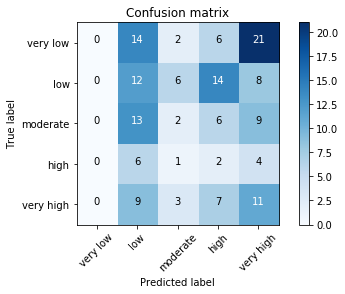

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:15.499132. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [304]:
plot_confusion_matrix(cm, classes=classes)

In [305]:
accuracy(cm)

0.17307692307692307

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/simplejson/encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-07-31 12:10:15.940873. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
